# ST456 Group 17 Project
## Forecasting S&P 500 Volatility using LTSM Neural Network

### Data Preperation

In [137]:
!pip install arch
!pip install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [138]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arch
from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, Dropout, Conv2D, MaxPooling2D, Flatten, concatenate
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from IPython.display import display
from pyts.image import GramianAngularField

In [139]:
data = pd.read_csv("spy.us.txt")

We will use the SPY ETF to compute the volatility of the S&P 500.

In [140]:
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,104.77,106.00,104.68,105.79,70221808,0
1,2005-02-28,105.55,105.68,104.56,105.08,79695344,0
2,2005-03-01,105.22,105.87,105.22,105.62,54607412,0
3,2005-03-02,105.21,106.22,105.10,105.57,73733090,0
4,2005-03-03,105.99,106.20,105.15,105.61,71286823,0


In [141]:
# Add column containing log returns
data['Log_Return'] = np.log(data['Close']) - np.log(data['Close'].shift(1))

In [142]:
# Add columns containing 10 day volatility and 30 day volatility
data['10D_Volatility'] = data['Log_Return'].rolling(window=10).std()
data['30D_Volatility'] = data['Log_Return'].rolling(window=30).std()

In [143]:
#Create Open High Low Close Data
OHLC = np.log(data[['Open','High','Low', 'Close']])
OHLC[["10D_Volatility", "30D_Volatility"]] = data[["10D_Volatility", "30D_Volatility"]] 
OHLC = OHLC.dropna()
OHLC.head()

,Open,High,Low,Close,10D_Volatility,30D_Volatility
30,4.635117,4.636281,4.631325,4.633660,0.006984,0.006407
31,4.631812,4.641695,4.624777,4.638702,0.006584,0.006399
32,4.637444,4.639572,4.625365,4.626736,0.006331,0.006635
33,4.628007,4.628594,4.613733,4.613733,0.007431,0.006979
34,4.613436,4.617296,4.599142,4.599544,0.008380,0.007340


In [144]:
# Remove undesired variables
data = data[["Date", "Log_Return", "10D_Volatility", "30D_Volatility"]]

# Remove first 30 rows containing Nans
data = data.dropna()

In [145]:
print(len(data), len(OHLC))

3171 3171


Approach:

fix the training window length e.g. 1 year, 5 years 

use data from time x to time t+x to predict point t+1+x

In [146]:
split = 4* len(data)//5
train = np.array(data["30D_Volatility"])[:split]
test = np.array(data["30D_Volatility"])[split:]

In [147]:
# Prepare vol data of window length "window_length" for LSTM input. 
def split_data(window_length, train=train, test=test):
  X_train = []
  X_test = []
  y_train = []
  y_test = []

  for i in range(len(train) - window_length):
    train_row = []
    for j in range(window_length):
      train_row.append(train[i+j])
    
    X_train.append(train_row)
    y_train.append(train[i + window_length])

  for i in range(len(test) - window_length):
    test_row = []
    for j in range(window_length):
      test_row.append(test[i+j])

    X_test.append(test_row)
    y_test.append(test[i + window_length])

  X_train = np.array(X_train)
  X_test = np.array(X_test)
  y_train = np.array(y_train)
  y_test = np.array(y_test)

  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
  y_train = y_train.reshape(y_train.shape[0], 1)
  y_test = y_test.reshape(y_test.shape[0], 1)

  return X_train, X_test, y_train, y_test

In [148]:
# Vol data
X_train, X_test, y_train, y_test = split_data(50)

In [149]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2486, 50, 1) (2486, 1) (585, 50, 1) (585, 1)


### Single Layer LSTM Model with Vol Data

We will train our models using the huber loss function as it is less sensitive to outliers than MSE and less sensitive to small errors than MAE. 

In [17]:
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(X_train.shape[1],1)))
model.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimizer, loss='huber', metrics=["mape"])

history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
78/78 [==============================] - 8s 68ms/step - loss: 9.9864e-06 - mape: 30.6828 - val_loss: 2.9246e-06 - val_mape: 43.1053
Epoch 2/100
78/78 [==============================] - 5s 62ms/step - loss: 2.0217e-06 - mape: 13.0453 - val_loss: 8.6928e-07 - val_mape: 13.2373
Epoch 3/100
78/78 [==============================] - 3s 37ms/step - loss: 1.3769e-06 - mape: 10.5244 - val_loss: 9.5196e-07 - val_mape: 18.8238
Epoch 4/100
78/78 [==============================] - 3s 36ms/step - loss: 1.2150e-06 - mape: 9.8158 - val_loss: 6.0995e-07 - val_mape: 10.3725
Epoch 5/100
78/78 [==============================] - 4s 47ms/step - loss: 1.1999e-06 - mape: 10.2120 - val_loss: 8.6955e-07 - val_mape: 14.5055
Epoch 6/100
78/78 [==============================] - 5s 71ms/step - loss: 1.0615e-06 - mape: 9.1950 - val_loss: 5.6398e-07 - val_mape: 11.5545
Epoch 7/100
78/78 [==============================] - 3s 43ms/step - loss: 9.4324e-07 - mape: 8.6930 - val_loss: 4.8958e-07 - val_mape: 8.9

(0.0, 40.0)

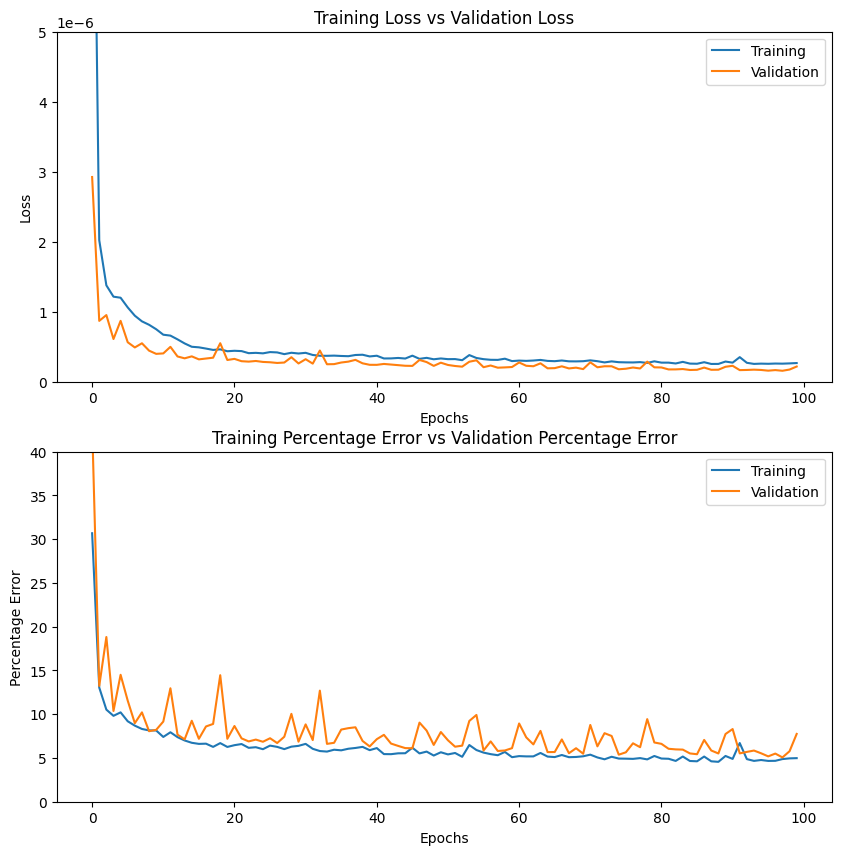

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(['Training', 'Validation'])
axs[0].set_ylim([0, 0.5 * 1e-5])

axs[1].plot(history.history['mape'])
axs[1].plot(history.history['val_mape'])
axs[1].title.set_text('Training Percentage Error vs Validation Percentage Error')
axs[1].legend(['Training', 'Validation'])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Percentage Error")
axs[1].set_ylim([0, 40])

### Simple Layer LSTM Model with OHLC Data

Some research papers suggest that using OHLC data would yeild lower MSEs. We will attempt this.

In [90]:
OHLCtrain = np.array(OHLC[['Open','High','Low', 'Close']])[:split]
OHLCtest = np.array(OHLC[['Open','High','Low', 'Close']])[split:]

In [91]:
def split_OHLCdata(window_length, OHLCtrain=OHLCtrain, OHLCtest=OHLCtest, train=train, test=test):
  X_train = []
  X_test = []
  y_train = []
  y_test = []

  for i in range(len(OHLCtrain) - window_length):
    train_row = []
    for j in range(window_length):
      train_row.append(OHLCtrain[i+j])
    
    X_train.append(train_row)
    y_train.append(train[i + window_length])

  for i in range(len(OHLCtest) - window_length):
    test_row = []
    for j in range(window_length):
      test_row.append(OHLCtest[i+j])

    X_test.append(test_row)
    y_test.append(test[i + window_length])

  X_train = np.array(X_train)
  X_test = np.array(X_test)
  y_train = np.array(y_train)
  y_test = np.array(y_test)

  y_train = y_train.reshape(y_train.shape[0], 1)
  y_test = y_test.reshape(y_test.shape[0], 1)

  return X_train, X_test, y_train, y_test

In [92]:
OHLCX_train, OHLCX_test, OHLCy_train, OHLCy_test = split_OHLCdata(50)

In [93]:
print(OHLCX_train.shape, OHLCy_train.shape, OHLCX_test.shape, OHLCy_test.shape)

(2486, 50, 4) (2486, 1) (585, 50, 4) (585, 1)


In [94]:
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(OHLCX_train.shape[1],OHLCX_train.shape[2])))
model.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimizer, loss='huber', metrics=["mape"])

history = model.fit(OHLCX_train, OHLCy_train, batch_size=32, epochs=100, validation_data=(OHLCX_test, OHLCy_test))

Epoch 1/100
78/78 [==============================] - 7s 43ms/step - loss: 0.0052 - mape: 721.0178 - val_loss: 8.2258e-04 - val_mape: 737.1143
Epoch 2/100
78/78 [==============================] - 2s 30ms/step - loss: 1.9770e-04 - mape: 155.8240 - val_loss: 3.1933e-04 - val_mape: 460.7007
Epoch 3/100
78/78 [==============================] - 2s 31ms/step - loss: 3.3613e-05 - mape: 61.2152 - val_loss: 1.0337e-05 - val_mape: 68.7107
Epoch 4/100
78/78 [==============================] - 2s 31ms/step - loss: 1.9004e-05 - mape: 43.0627 - val_loss: 8.8733e-06 - val_mape: 50.9984
Epoch 5/100
78/78 [==============================] - 3s 44ms/step - loss: 1.8805e-05 - mape: 43.2519 - val_loss: 8.8576e-06 - val_mape: 56.0622
Epoch 6/100
78/78 [==============================] - 2s 30ms/step - loss: 1.8392e-05 - mape: 42.5722 - val_loss: 9.0940e-06 - val_mape: 54.9428
Epoch 7/100
78/78 [==============================] - 3s 41ms/step - loss: 1.8422e-05 - mape: 42.8144 - val_loss: 1.0161e-05 - val_mape: 

(0.0, 100.0)

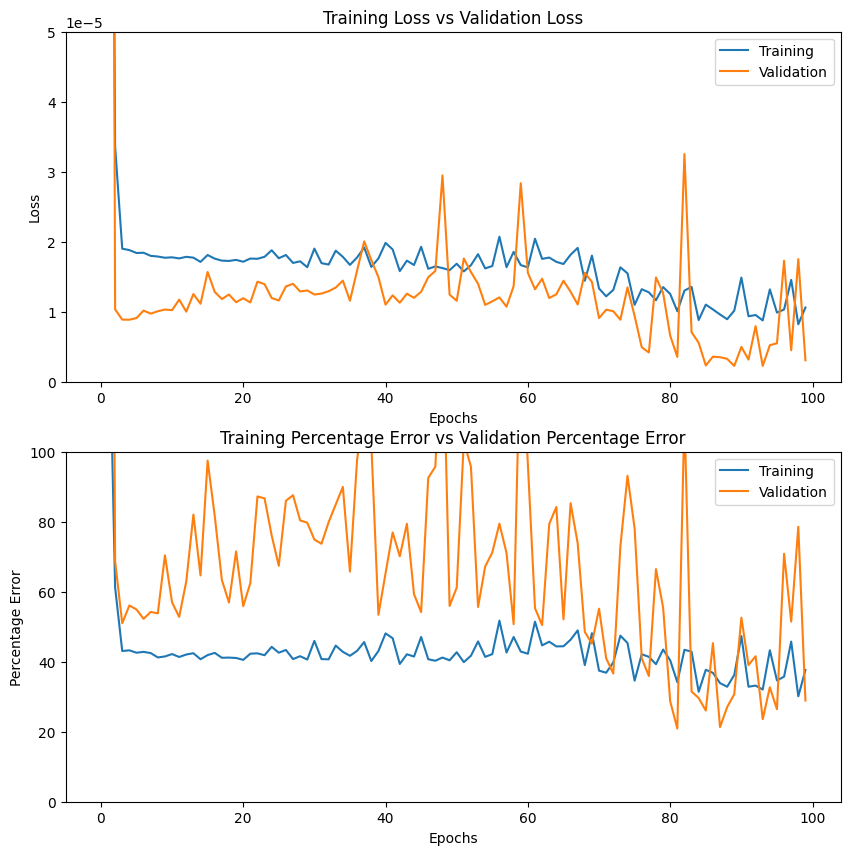

In [97]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(['Training', 'Validation'])
axs[0].set_ylim([0, 5 * 1e-5])

axs[1].plot(history.history['mape'])
axs[1].plot(history.history['val_mape'])
axs[1].title.set_text('Training Percentage Error vs Validation Percentage Error')
axs[1].legend(['Training', 'Validation'])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Percentage Error")
axs[1].set_ylim([0, 100])

We immediately observe that the OHLC data performs far worse at predicting volatility. Intuitively, this makes sense as we would except past volatility to better predict volatility itself than using daily open, high, low, closing prices.

### Multi-Layered LSTM Model

In the subsequent models, we will use the optimal window length found in the first model which is ___. From research papers, it has been suggested that multiple layers of LSTM could help improve the performance of the model. It was also suggested that the RMSprop optimizer is the most suitable optimizer. We will implement these changes and see if the models performance improves. 

In [19]:
model2 = Sequential()
model2.add(LSTM(64, activation='tanh', input_shape=(X_train.shape[1],1), return_sequences=True))
model2.add(LSTM(32, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss='huber', metrics=["mape"])

history2 = model2.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
78/78 [==============================] - 10s 69ms/step - loss: 3.1757e-05 - mape: 55.6798 - val_loss: 2.3179e-05 - val_mape: 124.9966
Epoch 2/100
78/78 [==============================] - 6s 78ms/step - loss: 2.6776e-05 - mape: 50.3658 - val_loss: 6.4191e-06 - val_mape: 59.5015
Epoch 3/100
78/78 [==============================] - 6s 75ms/step - loss: 2.5678e-05 - mape: 48.9400 - val_loss: 5.8534e-06 - val_mape: 50.1218
Epoch 4/100
78/78 [==============================] - 5s 62ms/step - loss: 2.5206e-05 - mape: 47.9891 - val_loss: 2.7855e-05 - val_mape: 137.0245
Epoch 5/100
78/78 [==============================] - 5s 69ms/step - loss: 2.4335e-05 - mape: 48.0276 - val_loss: 1.0030e-05 - val_mape: 80.4333
Epoch 6/100
78/78 [==============================] - 5s 59ms/step - loss: 2.5078e-05 - mape: 49.0745 - val_loss: 7.0592e-06 - val_mape: 63.7101
Epoch 7/100
78/78 [==============================] - 6s 74ms/step - loss: 2.3870e-05 - mape: 46.9398 - val_loss: 1.1129e-05 - val_map

(0.0, 100.0)

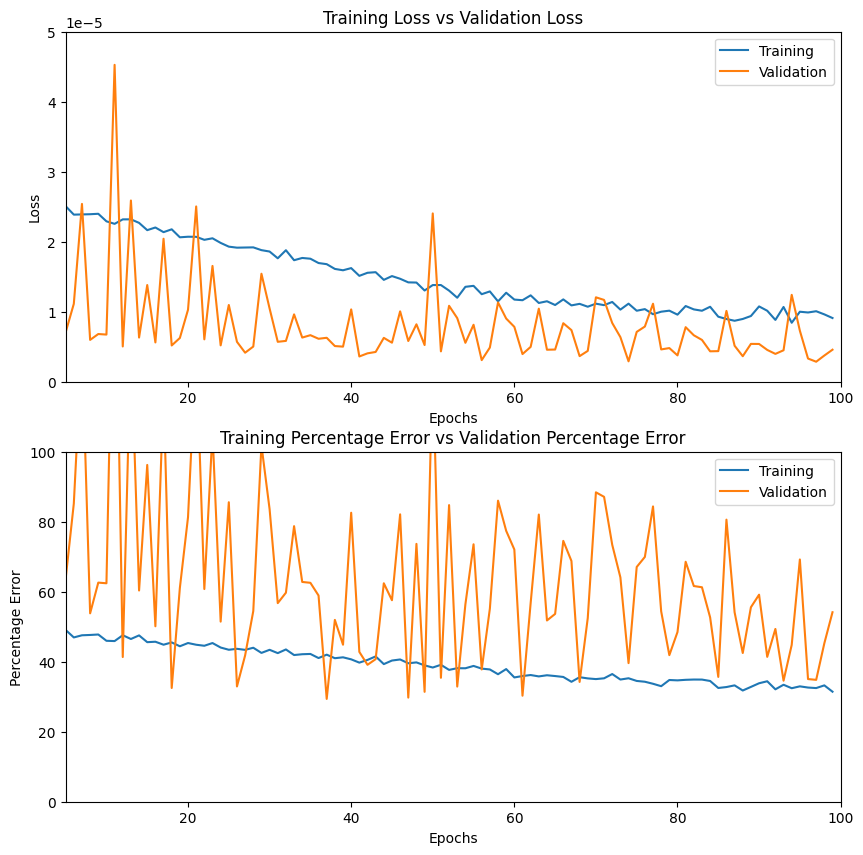

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(history2.history['loss'])
axs[0].plot(history2.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(['Training', 'Validation'])
axs[0].set_xlim([5, 100])
axs[0].set_ylim([0, 0.5 * 1e-4])

axs[1].plot(history2.history['mape'])
axs[1].plot(history2.history['val_mape'])
axs[1].title.set_text('Training Percentage Error vs Validation Percentage Error')
axs[1].legend(['Training', 'Validation'])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Percentage Error")
axs[1].set_xlim([5, 100])
axs[1].set_ylim([0, 100])

We notice that the RMSprop optimizer does not seem to perform well with our dataset and model. We tested the RMSprop optimizer with differnt learning rates to no avail. This is likely because 

In [21]:
model2 = Sequential()
model2.add(LSTM(64, activation='tanh', input_shape=(X_train.shape[1],1), return_sequences=True))
model2.add(LSTM(32, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model2.compile(optimizer=optimizer, loss='huber', metrics=["mape"])

history2 = model2.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
78/78 [==============================] - 10s 85ms/step - loss: 1.5763e-05 - mape: 36.3856 - val_loss: 2.6204e-06 - val_mape: 22.8719
Epoch 2/100
78/78 [==============================] - 4s 56ms/step - loss: 4.2208e-06 - mape: 19.3079 - val_loss: 1.9002e-06 - val_mape: 21.1112
Epoch 3/100
78/78 [==============================] - 5s 64ms/step - loss: 3.9449e-06 - mape: 19.5720 - val_loss: 3.2066e-06 - val_mape: 43.4647
Epoch 4/100
78/78 [==============================] - 5s 67ms/step - loss: 3.1389e-06 - mape: 17.7113 - val_loss: 1.6073e-06 - val_mape: 27.9579
Epoch 5/100
78/78 [==============================] - 4s 56ms/step - loss: 3.0854e-06 - mape: 16.3847 - val_loss: 1.8909e-06 - val_mape: 32.1912
Epoch 6/100
78/78 [==============================] - 6s 73ms/step - loss: 2.4934e-06 - mape: 15.1303 - val_loss: 1.2714e-06 - val_mape: 22.6922
Epoch 7/100
78/78 [==============================] - 4s 56ms/step - loss: 2.1648e-06 - mape: 14.3798 - val_loss: 1.4705e-06 - val_mape:

(0.0, 50.0)

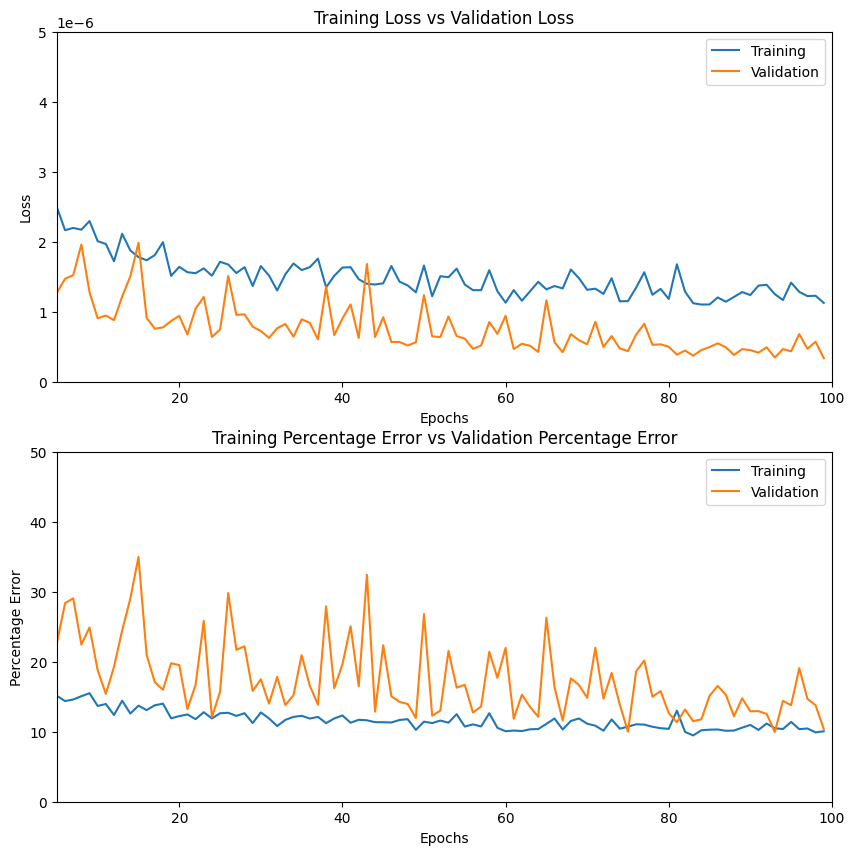

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(history2.history['loss'])
axs[0].plot(history2.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(['Training', 'Validation'])
axs[0].set_xlim([5, 100])
axs[0].set_ylim([0, 0.5 * 1e-5])

axs[1].plot(history2.history['mape'])
axs[1].plot(history2.history['val_mape'])
axs[1].title.set_text('Training Percentage Error vs Validation Percentage Error')
axs[1].legend(['Training', 'Validation'])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Percentage Error")
axs[1].set_xlim([5, 100])
axs[1].set_ylim([0, 50])

It appears that the simplier models perform the best. This is likely because we are using a simple data set so a simplier model performs better.

### 2D-CNN-LSTM Model

Some research papers suggests that we should convert our time series data into an image with Gramian Angular Fields (GAF) and run it along with a parellel LSTM layer. We will attempt to do this with our volatility data.

In [150]:
X_train.reshape(X_train.shape[0],X_train.shape[1]).shape

(2486, 50)

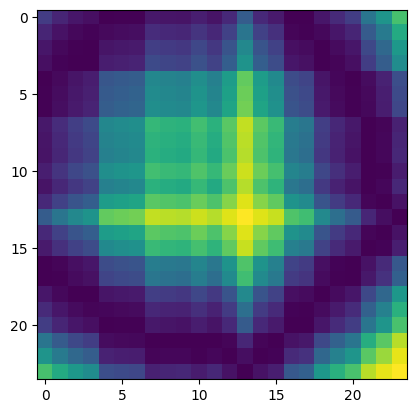

In [151]:
gaf = GramianAngularField(image_size=24)
im_X_train = gaf.fit_transform(X_train.reshape(X_train.shape[0],X_train.shape[1]))
im_X_test = gaf.transform(X_test.reshape(X_test.shape[0],X_test.shape[1]))

# plot one image
plt.imshow(im_X_train[0])
plt.show()

In [152]:
im_X_train = im_X_train.reshape(im_X_train.shape[0],im_X_train.shape[1],im_X_train.shape[2],1)
im_X_test = im_X_test.reshape(im_X_test.shape[0],im_X_test.shape[1],im_X_test.shape[2],1)
print(im_X_train.shape, im_X_test.shape)

(2486, 24, 24, 1) (585, 24, 24, 1)


In [171]:
# Input layers
input_cnn = Input(shape=(im_X_train.shape[1], im_X_train.shape[2], im_X_train.shape[3]))
input_lstm = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN branch
conv = Conv2D(32, (3,3), activation='relu')(input_cnn)
mp = MaxPooling2D((2,2)) (conv)
flat = Flatten()(mp)

# LSTM branch
lstm = LSTM(32, activation='tanh')(input_lstm)

combined = concatenate([flat, lstm])

output = Dense(1)(combined)
model = Model(inputs=[input_cnn, input_lstm], outputs=output)

In [172]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 24, 24, 1)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 22, 22, 32)   320         ['input_15[0][0]']               
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 11, 11, 32)  0           ['conv2d_7[0][0]']               
                                                                                                  
 input_16 (InputLayer)          [(None, 50, 1)]      0           []                               
                                                                                            

In [173]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='huber', metrics=["mape"])

history = model.fit([im_X_train, X_train], y_train, batch_size=32, epochs=200, validation_data=([im_X_test, X_test], y_test))

Epoch 1/200
78/78 [==============================] - 14s 111ms/step - loss: 0.0624 - mape: 2121.4915 - val_loss: 8.4167e-04 - val_mape: 478.8193
Epoch 2/200
78/78 [==============================] - 3s 42ms/step - loss: 3.3731e-04 - mape: 230.3295 - val_loss: 2.8987e-04 - val_mape: 284.2010
Epoch 3/200
78/78 [==============================] - 3s 33ms/step - loss: 1.6229e-04 - mape: 163.3628 - val_loss: 2.1726e-04 - val_mape: 255.9505
Epoch 4/200
78/78 [==============================] - 3s 33ms/step - loss: 1.2855e-04 - mape: 141.4541 - val_loss: 2.4487e-04 - val_mape: 264.6748
Epoch 5/200
78/78 [==============================] - 3s 34ms/step - loss: 9.0275e-05 - mape: 122.2255 - val_loss: 1.8425e-04 - val_mape: 224.0375
Epoch 6/200
78/78 [==============================] - 4s 52ms/step - loss: 7.6640e-05 - mape: 114.2531 - val_loss: 1.6342e-04 - val_mape: 213.1270
Epoch 7/200
78/78 [==============================] - 3s 36ms/step - loss: 6.1482e-05 - mape: 102.6234 - val_loss: 1.0577e-04 

(0.0, 40.0)

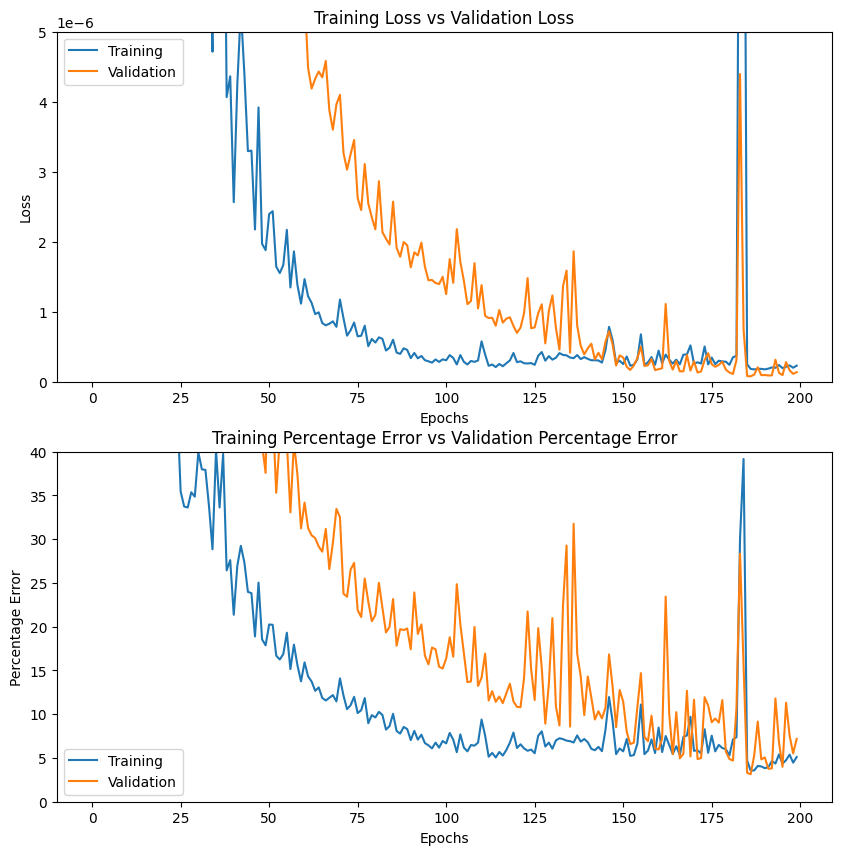

In [174]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(['Training', 'Validation'])
axs[0].set_ylim([0, 0.5 * 1e-5])

axs[1].plot(history.history['mape'])
axs[1].plot(history.history['val_mape'])
axs[1].title.set_text('Training Percentage Error vs Validation Percentage Error')
axs[1].legend(['Training', 'Validation'])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Percentage Error")
axs[1].set_ylim([0, 40])

We notice that the model is able to perform very well, even better than the simple LSTM model however the validation errors are very volatile and never reaches convergence. It is highly likely that the model would not be able to produce such a low MAPE on a test set. 

### 1D-CNN-LSTM Model

In [ ]:
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=(X_train.shape[1], X_train.shape[2])),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, activation='tanh', return_sequences=True)),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, activation='relu', return_sequences=True)),
  tf.keras.layers.Dropout(0.15),

  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

model3.compile(loss='huber', optimizer="Adam", metrics=["mape"])
history3 = model3.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
78/78 [==============================] - 60s 631ms/step - loss: 0.0593 - mape: 1419.6339 - val_loss: 8.5810e-05 - val_mape: 189.2586
Epoch 2/50
78/78 [==============================] - 44s 559ms/step - loss: 6.3116e-05 - mape: 86.7217 - val_loss: 2.1808e-05 - val_mape: 108.1879
Epoch 3/50
78/78 [==============================] - 43s 553ms/step - loss: 3.6280e-05 - mape: 59.4007 - val_loss: 1.8349e-05 - val_mape: 108.8404
Epoch 4/50
78/78 [==============================] - 44s 559ms/step - loss: 3.4092e-05 - mape: 58.3617 - val_loss: 9.1565e-06 - val_mape: 73.9430
Epoch 5/50
78/78 [==============================] - 43s 553ms/step - loss: 2.9556e-05 - mape: 51.7400 - val_loss: 8.4419e-06 - val_mape: 70.0207
Epoch 6/50
78/78 [==============================] - 43s 547ms/step - loss: 3.3089e-05 - mape: 57.5657 - val_loss: 6.7232e-06 - val_mape: 38.3519
Epoch 7/50
78/78 [==============================] - 43s 547ms/step - loss: 3.2560e-05 - mape: 56.1053 - val_loss: 8.9432e-06 - va

(0.0, 200.0)

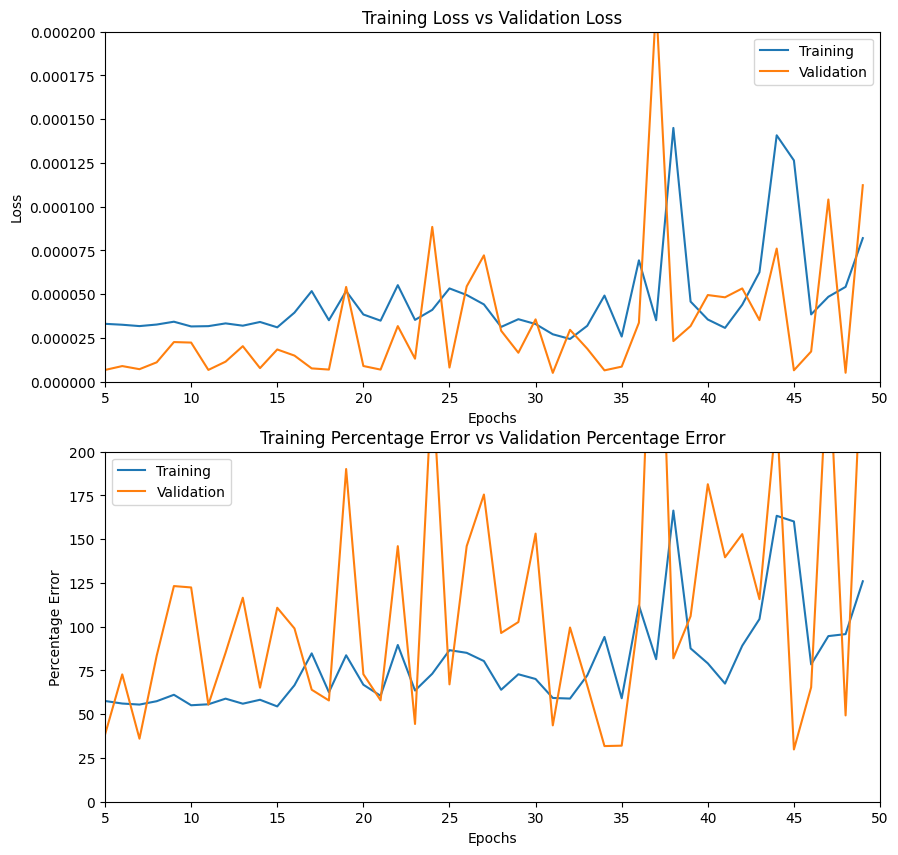

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(history3.history['loss'])
axs[0].plot(history3.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(['Training', 'Validation'])
axs[0].set_xlim([5, 50])
axs[0].set_ylim([0, 0.2 * 1e-3])

axs[1].plot(history3.history['mape'])
axs[1].plot(history3.history['val_mape'])
axs[1].title.set_text('Training Percentage Error vs Validation Percentage Error')
axs[1].legend(['Training', 'Validation'])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Percentage Error")
axs[1].set_xlim([5, 50])
axs[1].set_ylim([0, 200])

We notice that as the models become more and more complex, it performs worse and worse. It appears that the model perfroms best when it is simple. Thus we will use the simpliest model with one LSTM layer to select our optimal window length.

### Selecting Optimal LSTM Time Step (Window Length)

In [ ]:
# List of window lengths 
window_lengths = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50,60,80,100,120,140,160,180,200,220,240,260,280,300,400,500]
loss = []
mape = []
for window_length in window_lengths:
  X_train, X_test, y_train, y_test = split_data(window_length)

  model = Sequential()
  model.add(LSTM(64, activation='tanh', input_shape=(X_train.shape[1],1)))
  model.add(Dense(1))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
  model.compile(optimizer=optimizer, loss='mse', metrics=["mape"])
  model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))
  
  errors = model.evaluate(X_test, y_test)
  loss.append(errors[0])
  mape.append(errors[1])

Streaming output truncated to the last 5000 lines.
Epoch 14/100
80/80 [==============================] - 1s 8ms/step - loss: 1.6339e-06 - mape: 8.2046 - val_loss: 8.7323e-07 - val_mape: 8.3610
Epoch 15/100
80/80 [==============================] - 1s 8ms/step - loss: 1.5590e-06 - mape: 7.8183 - val_loss: 8.6548e-07 - val_mape: 8.2930
Epoch 16/100
80/80 [==============================] - 1s 7ms/step - loss: 1.5713e-06 - mape: 7.9526 - val_loss: 9.4773e-07 - val_mape: 10.0548
Epoch 17/100
80/80 [==============================] - 1s 7ms/step - loss: 1.5746e-06 - mape: 8.0096 - val_loss: 8.9066e-07 - val_mape: 8.2737
Epoch 18/100
80/80 [==============================] - 1s 8ms/step - loss: 1.6742e-06 - mape: 8.8156 - val_loss: 8.5181e-07 - val_mape: 7.8117
Epoch 19/100
80/80 [==============================] - 1s 7ms/step - loss: 1.5528e-06 - mape: 8.1114 - val_loss: 1.7777e-06 - val_mape: 19.3880
Epoch 20/100
80/80 [==============================] - 1s 8ms/step - loss: 1.5643e-06 - mape: 8.

Text(0, 0.5, 'Percentage Error')

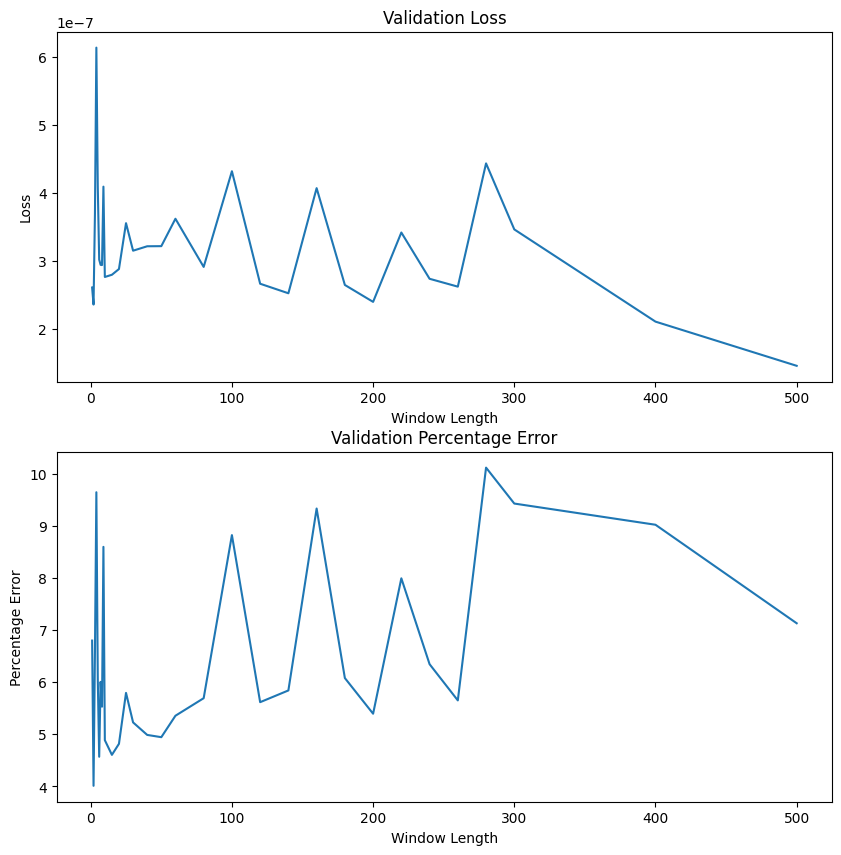

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(window_lengths, loss)
axs[0].title.set_text('Validation Loss')
axs[0].set_xlabel("Window Length")
axs[0].set_ylabel("Loss")

axs[1].plot(window_lengths, mape)
axs[1].title.set_text('Validation Percentage Error')
axs[1].set_xlabel("Window Length")
axs[1].set_ylabel("Percentage Error")

We notice that the model produces a lower validation MAPE at lower window lengths. Thus we will test the validation MAPE of window lengths 1 to 25.

In [25]:
window_lengths = range(1,26)
loss = []
mape = []
for window_length in window_lengths:
  X_train, X_test, y_train, y_test = split_data(window_length)

  model = Sequential()
  model.add(LSTM(64, activation='tanh', input_shape=(X_train.shape[1],1)))
  model.add(Dense(1))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
  model.compile(optimizer=optimizer, loss='mse', metrics=["mape"])
  model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))
  
  errors = model.evaluate(X_test, y_test)
  loss.append(errors[0])
  mape.append(errors[1])

Streaming output truncated to the last 5000 lines.
Epoch 14/100
80/80 [==============================] - 0s 5ms/step - loss: 7.3441e-06 - mape: 18.4296 - val_loss: 1.9568e-06 - val_mape: 23.6928
Epoch 15/100
80/80 [==============================] - 0s 5ms/step - loss: 5.2217e-06 - mape: 15.2272 - val_loss: 2.0818e-06 - val_mape: 25.4560
Epoch 16/100
80/80 [==============================] - 0s 5ms/step - loss: 3.6668e-06 - mape: 12.7775 - val_loss: 1.0096e-06 - val_mape: 16.8146
Epoch 17/100
80/80 [==============================] - 0s 4ms/step - loss: 2.4958e-06 - mape: 10.3222 - val_loss: 8.8429e-07 - val_mape: 16.0972
Epoch 18/100
80/80 [==============================] - 0s 5ms/step - loss: 1.6559e-06 - mape: 8.5088 - val_loss: 6.4344e-07 - val_mape: 13.5336
Epoch 19/100
80/80 [==============================] - 0s 4ms/step - loss: 1.1185e-06 - mape: 7.0065 - val_loss: 3.5815e-07 - val_mape: 9.2229
Epoch 20/100
80/80 [==============================] - 0s 5ms/step - loss: 7.6602e-07 - m

Text(0, 0.5, 'Percentage Error')

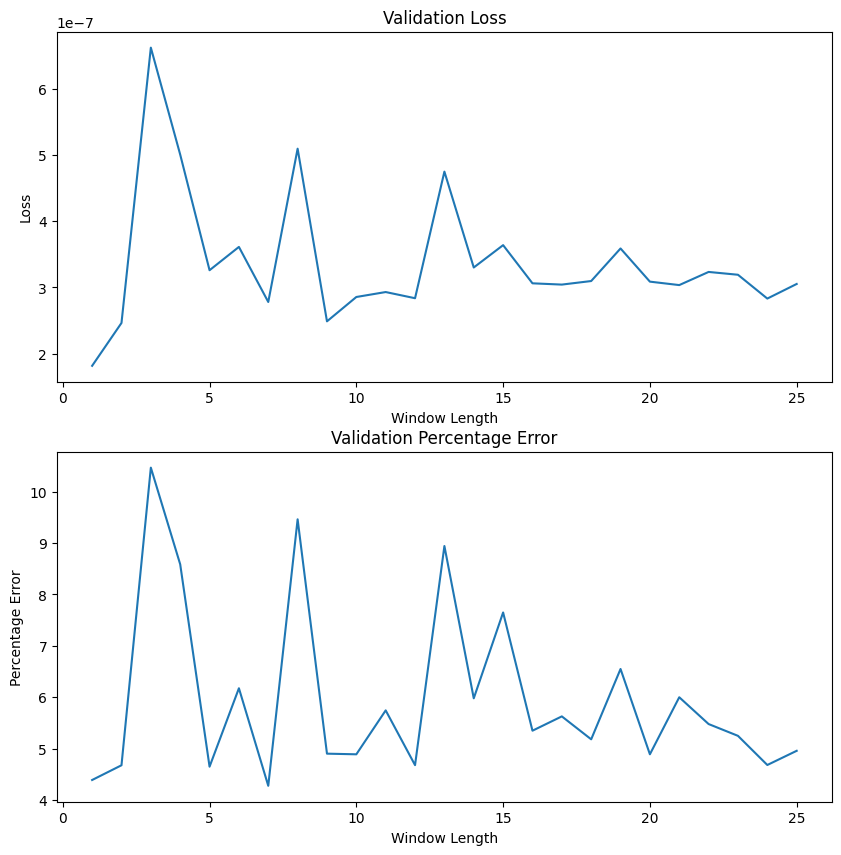

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(window_lengths, loss)
axs[0].title.set_text('Validation Loss')
axs[0].set_xlabel("Window Length")
axs[0].set_ylabel("Loss")

axs[1].plot(window_lengths, mape)
axs[1].title.set_text('Validation Percentage Error')
axs[1].set_xlabel("Window Length")
axs[1].set_ylabel("Percentage Error")

### Baseline Model (GARCH)

In [ ]:
garch_data = pd.read_csv("/Users/jathnielwong/Desktop/ST456/Project/ST456 Project Data/ETFs/spy.us.txt")
garch_data['Log_Return'] = np.log(garch_data['Close']) - np.log(garch_data['Close'].shift(1))

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
scaler = StandardScaler()
garch_data["Transformed_Return"] = scaler.fit_transform(garch_data[['Log_Return']])

In [ ]:
garch_data['30D_Volatility'] = garch_data['Transformed_Return'].rolling(window=30).std()
garch_data = garch_data[["Date", "Transformed_Return", "30D_Volatility"]]
garch_data.Date = pd.to_datetime(garch_data.Date)
garch_data.set_index('Date', inplace=True)
garch_data = garch_data.dropna()

In [ ]:
garch_data['10D_Volatility'] = garch_data['Transformed_Return'].rolling(window=10).std()

In [ ]:
# Choosing optimal GARCH parameters
aics = []
bics = []
params = []

for p in range(1,15):
    for q in range(1,15):
        param = [p,q]
        # create GARCH model
        garch = arch.arch_model(garch_data.iloc[:,0], p=p, q=q)
        # estimate model parameters
        results = garch.fit(disp='off')
        # calculate AIC and BIC
        aic = results.aic
        bic = results.bic
        # store AIC and BIC
        params.append(param)
        aics.append(aic)
        bics.append(bic)

In [ ]:
results = pd.DataFrame({'Parameters': params,
                        'AIC': aics,
                        'BIC': bics,
                        })
display(results.sort_values(by='AIC', ascending=True).head())
display(results.sort_values(by='BIC', ascending=True).head())

,Parameters,AIC,BIC
112,"[9, 1]",7053.731031,7126.362409
98,"[8, 1]",7054.099546,7120.678309
126,"[10, 1]",7054.758156,7133.442148
113,"[9, 2]",7055.731031,7134.415024
99,"[8, 2]",7056.099546,7128.730924


,Parameters,AIC,BIC
0,"[1, 1]",7062.818037,7087.028496
14,"[2, 1]",7057.557266,7087.820341
15,"[2, 2]",7056.552822,7092.868511
1,"[1, 2]",7064.818038,7095.081112
28,"[3, 1]",7059.557266,7095.872955


In [ ]:
# we will cross validate the best 3 models for which produced the lowest AIC and BIC.
bestparams = [[9,1], [8,1], [10,1], [1,1], [2,1], [2,2]]
mses = []
tscv = TimeSeriesSplit(n_splits=10)

for i in range(len(bestparams)):
    p,q = bestparams[i]
    for train_index, val_index in tscv.split(garch_data):
        train_data = garch_data.iloc[train_index]
        val_data = garch_data.iloc[val_index]
    
        model = arch.arch_model(train_data.iloc[:,0], vol='GARCH', p=p, q=q)
        res = model.fit(disp='off')
    
        forecasts = res.forecast(horizon=len(val_data), reindex=False)
        preds = np.sqrt(forecasts.variance.values[-1, :])

        mse = ((preds - val_data.iloc[:,1]) ** 2).mean()
        mses.append(mse)

In [ ]:
cv_errors = []
for i in range(6):
    temp = np.array(mses[10*i:10*i + 10]).mean()
    cv_errors.append(temp)

In [ ]:
cv_errors

[1.6456001155414188,
 1.608836495305383,
 1.6458919595281372,
 0.492086281954506,
 0.36252890909698987,
 0.41492628909673873]

The GARCH(2,1) has the lowest cross validation error so we will use this as our benchmark to compare against the performance of the LSTM networks. We will now use train the GARCH model with data up to time t to produce a forecast for t+1 for a fair comparison. We will do this for 530 days as we need an additional 30 days to calculate 500 days of 30 day volatility.

In [ ]:
pred_vol = np.zeros(530)
for i in range(1,531):
    train_data = garch_data.iloc[:-i,0]
    
    model = arch.arch_model(train_data, vol='GARCH', p=2, q=1)
    mdl = model.fit(disp='off')
    
    forecast = mdl.forecast(horizon=1, reindex=False)
    pred_vol[-i] = np.sqrt(forecast.variance.values[-1, :])

In [ ]:
garch_data.index[-530:]

DatetimeIndex(['2015-10-07', '2015-10-08', '2015-10-09', '2015-10-12',
               '2015-10-13', '2015-10-14', '2015-10-15', '2015-10-16',
               '2015-10-19', '2015-10-20',
               ...
               '2017-10-30', '2017-10-31', '2017-11-01', '2017-11-02',
               '2017-11-03', '2017-11-06', '2017-11-07', '2017-11-08',
               '2017-11-09', '2017-11-10'],
              dtype='datetime64[ns]', name='Date', length=530, freq=None)

In [ ]:
pred_vol = pd.Series(pred_vol, index=garch_data.index[-530:])

In [ ]:
garch_data['1YR_Volatility'] = garch_data['Transformed_Return'].rolling(window=252).std()

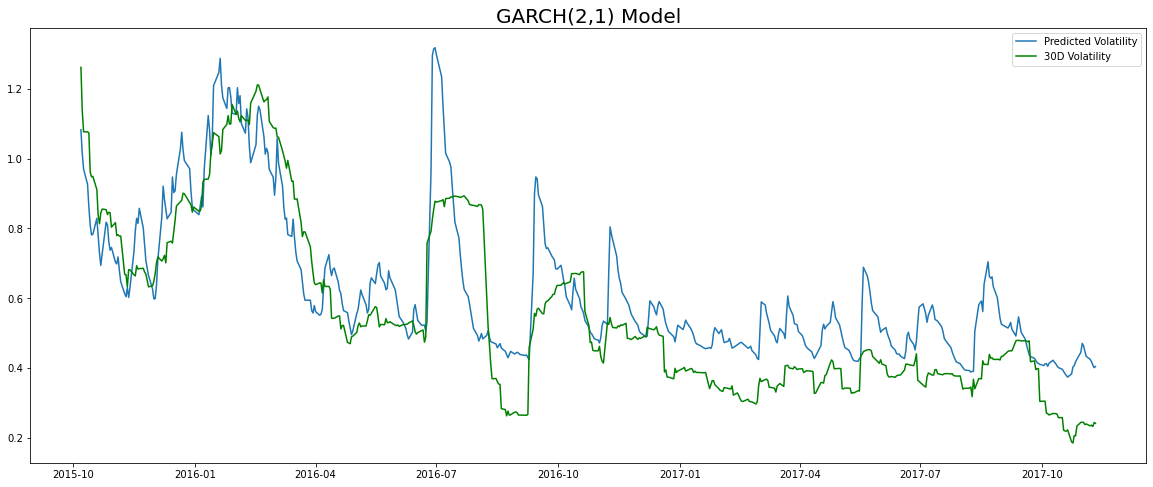

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(pred_vol, label='Predicted Volatility')
plt.plot(garch_data.iloc[-530:,1], color='green', label='30D Volatility')
#plt.plot(garch_data.iloc[-530:,2], color='orange', label='10D Volatility')
plt.title('GARCH(2,1) Model', fontsize=20)

plt.legend()

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mape(garch_data.iloc[-530:,1], pred_vol)

25.820032034837677

### Results

Initial Models
* 50 Day window length simple LSTM model with vol data with Adam optimizer - 5% MAPE (slight overfiting)
* 50 Day window length simple LSTM model with OHLC data with Adam optimizer - 28% MAPE (significant overfiting)
* 50 Day window length multi layered LSTM model with RMSprop optimizer - Final MAPE of 54% MAPE, lowest MAPE of 34% (significant overfitting)
* 50 Day window length multi layered LSTM model with Adam optimizer - 10% MAPE (overfitting)
* 50 Day window length parellel 1D-CNN-LSTM model with Adam optimizer - 7 %MAPE (very significant overfitting) (although some epochs are 3% and some are 30%, refer to the graphs for this section)
* 50 Day window length 2D-CNN-LSTM model with Adam optimizer - Final MAPE of 269%, lowest MAPE of 29% (very significant overfitting)



Optimized Models
* 7 Day window length simple LSTM model with Adam optimizer - 4% MAPE
* GARCH(2,1) Model - 26% MAPE


We see that a well tuned LSTM model is able to perform far better than well tuned GARCH model for predicing recent S&P 500 volatility. Whilst the garch model was able to achieve a MAPE of 25.8%, the best LSTM model was able to achieve a MAPE of close to 4%. After running the LSTM for different window lengths, we find that shorter window lengths tend to perform better than longer window lengths, meaning that more recent information on volatility has a larger effect on future volatility. We also note that the model its self is not particularly sensitive to the window length as it is able to perform well for all window lengths.